In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
import matplotlib.pyplot as plt
from agent import Agent
from collections import deque

import torch

In [2]:
#env = UnityEnvironment(file_name='Reacher.app')

env = UnityEnvironment(file_name='Multi_Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
#reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i = 0
while True:
    i+=1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print(i)
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

1001
Total score (averaged over agents) this episode: 0.12499999720603228


In [6]:
state_dim = int(env_info.vector_observations.shape[1])
action_dim = int(brain.vector_action_space_size)

In [7]:
def ddpg(n_episodes=10, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    agents =[] 
    
    for i in range(num_agents):
        agents.append(Agent(state_dim, action_dim, random_seed=0))
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
            
        for t in range(max_t):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)]).squeeze(1)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            rewards = [0.1 if rew > 0 else 0 for rew in rewards]
            dones = env_info.local_done        
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) 
            states = next_states
            scores += rewards
            print('\rEpisode {}\tStep: {:.2f}\t Score: {:.2f}'.format(i_episode, t, np.mean(scores)), end="")
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            for i, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor_'+str(i+1)+'.pth')
                torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic_'+str(i+1)+'.pth')
            break
            
    return scores_episode

In [8]:
scores = ddpg(n_episodes=300)

Episode 1	Score: 1.78	Average Score: 1.78
Episode 2	Score: 1.10	Average Score: 1.44
Episode 3	Score: 1.20	Average Score: 1.36
Episode 4	Score: 1.67	Average Score: 1.43
Episode 5	Score: 1.23	Average Score: 1.39
Episode 6	Score: 1.25	Average Score: 1.37
Episode 7	Score: 1.17	Average Score: 1.34
Episode 8	Score: 1.63	Average Score: 1.37
Episode 9	Score: 1.30	Average Score: 1.37
Episode 10	Score: 1.42	Average Score: 1.37
Episode 11	Score: 2.25	Average Score: 1.45
Episode 12	Score: 2.23	Average Score: 1.52
Episode 13	Score: 2.14	Average Score: 1.56
Episode 14	Score: 2.30	Average Score: 1.62
Episode 15	Score: 2.79	Average Score: 1.70
Episode 16	Score: 1.78	Average Score: 1.70
Episode 17	Score: 2.03	Average Score: 1.72
Episode 18	Score: 2.75	Average Score: 1.78
Episode 19	Score: 2.55	Average Score: 1.82
Episode 20	Score: 2.58	Average Score: 1.86
Episode 21	Score: 2.30	Average Score: 1.88
Episode 22	Score: 2.86	Average Score: 1.92
Episode 23	Score: 2.41	Average Score: 1.94
Episode 24	Score: 2.

Episode 184	Score: 37.83	Average Score: 24.87
Episode 185	Score: 42.33	Average Score: 25.18
Episode 186	Score: 38.26	Average Score: 25.43
Episode 187	Score: 38.96	Average Score: 25.69
Episode 188	Score: 39.01	Average Score: 25.94
Episode 189	Score: 39.54	Average Score: 26.20
Episode 190	Score: 38.52	Average Score: 26.45
Episode 191	Score: 39.24	Average Score: 26.71
Episode 192	Score: 41.83	Average Score: 26.98
Episode 193	Score: 42.91	Average Score: 27.25
Episode 194	Score: 42.68	Average Score: 27.53
Episode 195	Score: 42.89	Average Score: 27.80
Episode 196	Score: 43.30	Average Score: 28.09
Episode 197	Score: 44.38	Average Score: 28.39
Episode 198	Score: 41.67	Average Score: 28.64
Episode 199	Score: 41.79	Average Score: 28.90
Episode 200	Score: 45.48	Average Score: 29.20
Episode 200	Average Score: 29.20
Episode 201	Score: 47.37	Average Score: 29.51
Episode 202	Score: 44.54	Average Score: 29.79
Episode 203	Score: 45.99	Average Score: 30.07

Environment solved in 203 episodes!	Average Sc

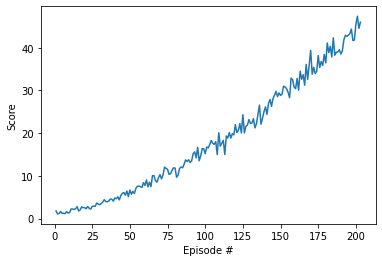

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Model Inference

In [39]:
from model import Actor, Critic

In [46]:
random_seed = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
agents = []

for i in range(num_agents):
    agents.append(Agent(state_dim, action_dim, random_seed=0))

for i in range(num_agents):
    #Load actor weights
    agents[i].actor_local = Actor(state_size, action_size, random_seed).to(device)
    agents[i].actor_local.load_state_dict(torch.load('models/checkpoint_actor_'+str(i+1)+'.pth', map_location=device))
    #Load critic weights
    agents[i].critic_local = Critic(state_size, action_size, random_seed).to(device)
    agents[i].critic_local.load_state_dict(torch.load('models/checkpoint_critic_'+str(i+1)+'.pth', map_location=device))

In [48]:
env_info = env.reset(train_mode=True)[brain_name] #reset env
scores = np.zeros(num_agents)
while True:
    actions = np.array([agents[i].act(states[i]) for i in range(num_agents)]).squeeze(1)
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations     
    rewards = env_info.rewards                     
    dones = env_info.local_done        

    states = next_states
    scores += rewards

    print('\rScore: {:.2f}'.format(np.mean(scores)), end="") 
    
    if np.any(dones):
        break

Score: 17.36